Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
API Runner iteration 1 completed
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
API Runner iteration 2 completed
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
API Runner iteration 3 completed


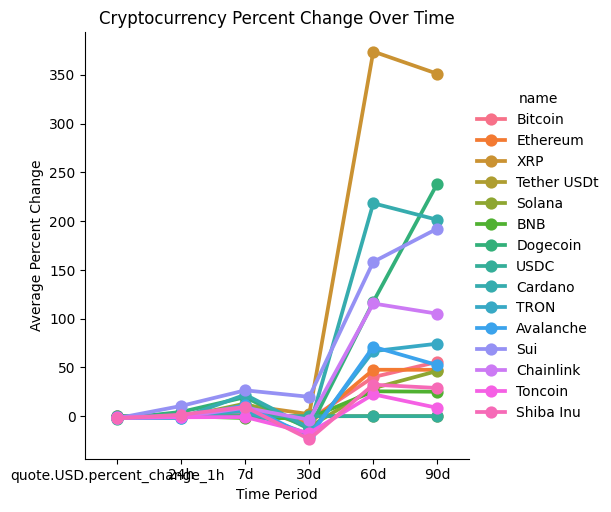

In [2]:
import os
from time import sleep
from google.colab import drive
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Set display options for better visualization in Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def api_runner():
    """
    Fetches cryptocurrency data from the CoinMarketCap API and appends the data to a CSV file in Google Drive.
    """
    global df

    # CoinMarketCap API endpoint and parameters
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    parameters = {
      'start': '1',
      'limit': '15',
      'convert': 'USD'
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': '0ad53085-1cb2-4eb8-ad9e-3ffbd7e56509',  # API key
    }

    session = Session()
    session.headers.update(headers)

    try:
        # Make a GET request to the API
        response = session.get(url, params=parameters)
        data = json.loads(response.text)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(f"API Request Error: {e}")
        return

    # Normalize JSON data into a Pandas DataFrame
    df = pd.json_normalize(data['data'])
    df['Timestamp'] = pd.to_datetime('now')

    # Save or append the data to Google Drive CSV file
    create_csv_gdrive(df)

def create_csv_gdrive(df):
    """
    Saves the DataFrame as a CSV file in Google Drive. If the file exists, appends the data.
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # File path in Google Drive
    file_path = '/content/drive/My Drive/API.csv'

    # Write or append to the file based on its existence
    if not os.path.isfile(file_path):
        df.to_csv(file_path, header='column_names', index=False)
    else:
        df.to_csv(file_path, mode='a', header=False, index=False)

    # Load the file to verify contents
    pd.read_csv(file_path)

# Main script: Run the API fetch and CSV update 333 times with 1-minute intervals
for i in range(3):
    api_runner()
    print(f'API Runner iteration {i+1} completed')
    sleep(60)  # Pause for 1 minute between iterations

# Perform data aggregation and transformation
# Group data by cryptocurrency name and calculate average percentage changes
if 'df' in globals():
    df_grouped = df.groupby('name', sort=False)[['quote.USD.percent_change_1h', 'quote.USD.percent_change_24h',
                                                 'quote.USD.percent_change_7d', 'quote.USD.percent_change_30d',
                                                 'quote.USD.percent_change_60d', 'quote.USD.percent_change_90d']].mean()

    # Transform data into a stacked format
    df_stacked = df_grouped.stack()
    df_frame = df_stacked.to_frame(name='values')

    # Reset index and rename columns for clarity
    df_index = df_frame.reset_index()
    df_renamed = df_index.rename(columns={'level_1': 'percent_change'})

    # Replace column names with readable labels
    df_renamed['percent_change'] = df_renamed['percent_change'].replace(
        ['quote.USD.percent_change_24h', 'quote.USD.percent_change_7d', 'quote.USD.percent_change_30d',
         'quote.USD.percent_change_60d', 'quote.USD.percent_change_90d'],
        ['24h', '7d', '30d', '60d', '90d']
    )

    # Visualize the data using Seaborn
    sns.catplot(x='percent_change', y='values', hue='name', data=df_renamed, kind='point')
    plt.title('Cryptocurrency Percent Change Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Average Percent Change')
    plt.show()


